In [1]:
from typing import Callable, Union

import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import numpy as np
import matplotlib.pyplot as plt 

import random
from pathlib import Path
from PIL import Image

from operator import itemgetter

import sys
sys.path.append('../src')
from utils import class2one_hot

In [19]:
def make_dataset(root, subset) -> list[tuple[Path, Path]]:
    assert subset in ["train", "val", "test"]

    root = Path(root)

    img_path = root / subset / "img"
    full_path = root / subset / "gt"

    images = sorted(img_path.glob("*.png"))
    full_labels = sorted(full_path.glob("*.png"))

    return list(zip(images, full_labels))

class SliceDataset(Dataset):
    def __init__(
        self,
        subset,
        root_dir,
        img_transform=None,
        gt_transform=None,
        augment=False,
        equalize=False,
        debug=False,
    ):
        self.root_dir: str = root_dir
        self.img_transform: Callable = img_transform
        self.gt_transform: Callable = gt_transform
        self.augmentation: bool = augment  # TODO: implement
        self.equalize: bool = equalize  # TODO: know if we need it

        # TODO make our own test set, now 5453 train and 1967 val
        self.files = make_dataset(root_dir, subset)
        if debug:
            self.files = self.files[:10]

        print(f">> Created {subset} dataset with {len(self)} images...")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index) -> dict[str, Union[Tensor, int, str]]:
        img_path, gt_path = self.files[index]

        img: Tensor = self.img_transform(Image.open(img_path))
        gt: Tensor = self.gt_transform(Image.open(gt_path))

        if self.augmentation:

            # Apply augmentation if random is above trheshold
            if random.random() > 0.0:

                a = None

                # Only apply one augmentation at a time
                random_val = random.random()

                if random_val < 0.1:
                    a = "hflip"
                    img = transforms.functional.vflip(img)
                    gt = transforms.functional.vflip(gt)

                if random_val < 0.3:
                    a = "rotation"
                    C = gt.size(-3)
                    angle = random.uniform(-5, 5)
                    img = TF.rotate(img, angle, interpolation=TF.InterpolationMode.BILINEAR)
                    class_indices = torch.argmax(gt, dim=-3)
                    rotated_class_indices = TF.rotate(class_indices.unsqueeze(0).float(), angle, interpolation=TF.InterpolationMode.NEAREST).squeeze(0).long()
                    gt = torch.nn.functional.one_hot(rotated_class_indices, num_classes=C).permute(-1, -3, -2)

                elif random_val < 0.8:
                    a = "crop"
                    original_size = img.shape[-2:]

                    # Custom cropping implementation
                    crop_size = (int(img.size(-2) / 1.1), int(img.size(-1) / 1.1))
                    i = random.randint(0, img.size(-2) - crop_size[0])
                    j = random.randint(0, img.size(-1) - crop_size[1])
                    img = img[:, i : i + crop_size[0], j : j + crop_size[1]]
                    gt = gt[:, i : i + crop_size[0], j : j + crop_size[1]]

                    # Bilinear interpolation to resize back to original size
                    img = torch.as_tensor(
                        F.interpolate(
                            img.float().unsqueeze(0),
                            size=original_size,
                            mode="bilinear",
                            align_corners=False,
                        ).squeeze(0)
                    )
                    gt = torch.as_tensor(
                        F.interpolate(
                            gt.float().unsqueeze(0),
                            size=original_size,
                            mode="nearest",
                        )
                        .squeeze(0)
                    ).long()

                else:
                    a = "noise"
                    noise = torch.randn(img.size()) * 0.01
                    img = img + noise
                    img = torch.clamp(img, 0, 1)

        _, W, H = img.shape
        K, _, _ = gt.shape
        assert gt.shape == (K, W, H)

        return {"images": img, "gts": gt, "stems": img_path.stem, "original_image": self.img_transform(Image.open(img_path)), "original_gt": self.gt_transform(Image.open(gt_path)), "a": a}

In [20]:
root_dir = "../" / Path("data") / "SEGTHOR"

K = 5  # Number of classes

img_transform = transforms.Compose(
    [
        lambda img: img.convert("L"),  # convert to grayscale
        lambda img: np.array(img)[np.newaxis, ...],
        lambda nd: nd / 255,  # max <= 1 (range [0, 1])
        lambda nd: torch.tensor(nd, dtype=torch.float32),
    ]
)


gt_transform = transforms.Compose(
    [
        lambda img: np.array(img)[...],
        # The idea is that the classes are mapped to {0, 255} for binary cases
        # {0, 85, 170, 255} for 4 classes
        # {0, 51, 102, 153, 204, 255} for 6 classes
        # Very sketchy but that works here and that simplifies visualization
        lambda nd: nd / (255 / (K - 1)) if K != 5 else nd / 63,  # max <= 1
        lambda nd: torch.tensor(nd, dtype=torch.int64)[
            None, ...
        ],  # Add one dimension to simulate batch
        lambda t: class2one_hot(t, K=K),
        itemgetter(0),
    ]
)

train_set = SliceDataset(
    "train",
    root_dir,
    img_transform=img_transform,
    gt_transform=gt_transform,
    debug=False,
    augment=True,
)
train_loader = DataLoader(
    train_set, batch_size=5, num_workers=4, shuffle=True,
)

>> Created train dataset with 5453 images...


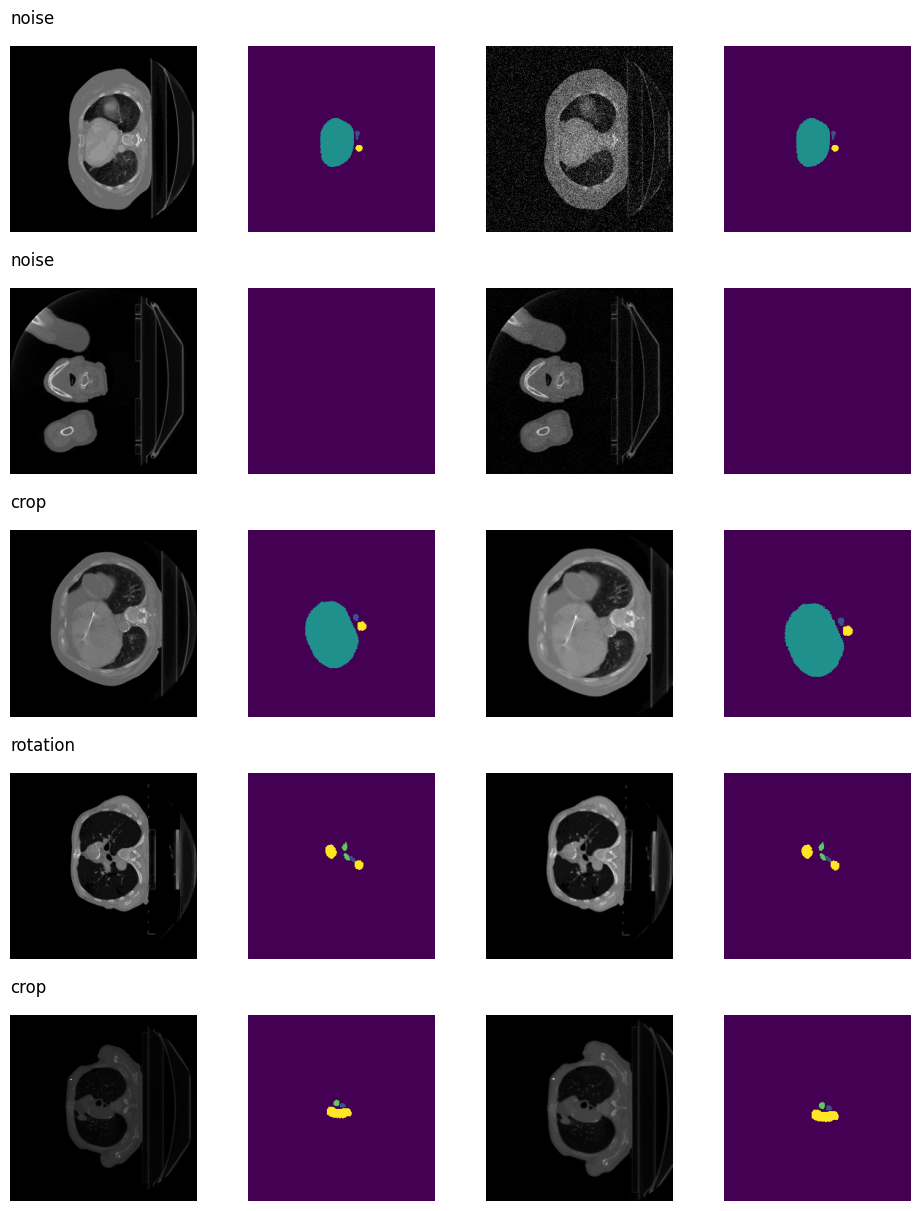

In [21]:
N = 5

fig, ax = plt.subplots(N, 4, figsize=(12, N*3))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

for idx, batch in enumerate(train_loader):
    if idx == N:
        break
    # title for this idx
    ax[idx, 0].annotate(batch["a"][0], xy=(0, 1.1),
            xycoords="axes fraction",
            fontsize=12,
            ha="left",
            va="bottom",
            color="black",
        )
    ax[idx, 0].imshow(batch["original_image"][0].squeeze(), cmap="gray")
    color_map = plt.get_cmap("viridis", K)
    gt_colored = color_map(batch["original_gt"][0].argmax(dim=0).cpu().numpy())
    ax[idx, 1].imshow(gt_colored)
    ax[idx, 2].imshow(batch["images"][0].squeeze(), cmap="gray")
    color_map = plt.get_cmap("viridis", K)
    gt_colored = color_map(batch["gts"][0].argmax(dim=0).cpu().numpy())
    ax[idx, 3].imshow(gt_colored, cmap="gray")

    for i in range(4):
        ax[idx, i].axis("off")